# Sentence embeddings
We will mainly use `sentence-transformers`, which is a dedicated package from Hugging Face 🤗. 

Relevant documentation
- Semantic textual similarity https://www.sbert.net/docs/usage/semantic_textual_similarity.html
- Semantic search https://www.sbert.net/examples/applications/semantic-search/README.html

### From word embeddings to sentence embeddings

In [14]:
try:
    from mai_nlp_helper_functions import *
except ImportError as e:
    raise ImportError("You don't have the mai_nlp_helper_functions.py file in the same directory as your note book. Either add it, or copy paste the contents in this cell") from e

In [15]:
import nest_asyncio
nest_asyncio.apply()

In [16]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import train_test_split
tqdm.pandas()

In [17]:
df = pd.read_csv("https://media.githubusercontent.com/media/JosPolfliet/vlerick-mai-nlp-2023/main/DATA/esg_reports.csv")
df["subject"] = df["subject"].fillna("Other")
df

,text,subject
0,"Since its inception in 2010, we have distribut...",Social
1,"I will focus first on traffic, which is a key ...",Other
2,"Also, many farms are aged with degraded soil t...",Environmental
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social
4,The company’s U.S. GOM operations can be impac...,Other
...,...,...
2180,American shad are a species of concern for res...,Environmental
2181,Weyerhaeuser's policies address best practices...,Other
2182,compares recently observed trends in weather p...,Environmental
2183,"If our partners, including our licensors, suff...",Other


In [18]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-MiniLM-L6-v2') # https://www.sbert.net/docs/pretrained_models.html

# Sentences we want to encode. Example:
sentence = df.iloc[302]

# Sentences are encoded by calling model.encode()
embedding = model.encode(sentence["text"])
print(f"Shape: {embedding.shape}")
embedding

Shape: (384,)


array([-0.09256149, -0.42923   , -0.1940513 , -0.20812997,  0.3887121 ,
        0.05996908, -0.4052988 , -0.12300907, -0.13854708,  0.1655856 ,
       -0.18656206, -0.00337574,  0.01154224, -0.14203285, -0.01295885,
        0.12488805, -0.13013142, -0.29453832,  0.40909117, -0.38689947,
       -0.6521384 , -0.48963892,  0.36488706, -0.23936453, -0.21317144,
       -0.13428761,  0.07301812, -0.08748028, -0.27836606, -0.06562182,
        0.15807995,  0.19137242,  0.05533346, -0.01790362, -0.32609546,
        0.07910851, -0.13638416, -0.11085165, -0.3085413 , -0.2529453 ,
        0.00459315, -0.18957312,  0.14105524, -0.0336583 ,  0.02829272,
       -0.12054776, -0.26604372,  0.31348324, -0.15021652, -0.4920502 ,
        0.44954318, -0.6702832 ,  0.264559  , -0.6560265 , -0.10691288,
        0.50342584,  0.31831467,  0.200367  ,  0.2870475 , -0.35019258,
        0.536377  , -0.6797642 , -0.00842874,  0.03310847,  0.36897954,
       -0.07891325, -0.05243663,  0.05798031,  0.01059717,  0.19

A sentence embedding is just a vector representing the whole sentence at ones. So we can use it directly as features too.

In [19]:
def embed_sentence_lm(sentence):
    sentence_embedding = model.encode(sentence["text"])
    return sentence_embedding

sentence_embedding = embed_sentence_lm(sentence)
print(sentence_embedding)
print(sentence_embedding.shape)

[-0.09256149 -0.42923    -0.1940513  -0.20812997  0.3887121   0.05996908
 -0.4052988  -0.12300907 -0.13854708  0.1655856  -0.18656206 -0.00337574
  0.01154224 -0.14203285 -0.01295885  0.12488805 -0.13013142 -0.29453832
  0.40909117 -0.38689947 -0.6521384  -0.48963892  0.36488706 -0.23936453
 -0.21317144 -0.13428761  0.07301812 -0.08748028 -0.27836606 -0.06562182
  0.15807995  0.19137242  0.05533346 -0.01790362 -0.32609546  0.07910851
 -0.13638416 -0.11085165 -0.3085413  -0.2529453   0.00459315 -0.18957312
  0.14105524 -0.0336583   0.02829272 -0.12054776 -0.26604372  0.31348324
 -0.15021652 -0.4920502   0.44954318 -0.6702832   0.264559   -0.6560265
 -0.10691288  0.50342584  0.31831467  0.200367    0.2870475  -0.35019258
  0.536377   -0.6797642  -0.00842874  0.03310847  0.36897954 -0.07891325
 -0.05243663  0.05798031  0.01059717  0.19111277 -0.13565008 -0.13307212
  0.62490714  0.22026724  0.32856223 -0.01637137  0.17515059  0.04583077
  0.45589682  0.10419751  0.17671575  0.24941383 -0.

In [20]:
%%time

df["features_simple"] = df.progress_apply(embed_sentence_lm,axis=1)


100%|████████████████████████████████████████████████████████████████████| 2185/2185 [00:26<00:00, 81.76it/s]

CPU times: user 19.7 s, sys: 16.4 s, total: 36.1 s
Wall time: 26.7 s


In [21]:
X = np.stack(df["features_simple"].values)
y = np.array(df["subject"])


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22141)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1638, 384)
X_test shape: (547, 384)
y_train shape: (1638,)
y_test shape: (547,)


In [23]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=3, random_state=22141, class_weight="balanced", n_estimators=600)
clf.fit(X_train, y_train)


CPU times: user 2.84 s, sys: 46.1 ms, total: 2.88 s
Wall time: 2.95 s


RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=600,
                       random_state=22141)

In [24]:
df.iloc[3]

text               Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...
subject                                                       Social
features_simple    [-0.004161255, -0.1882699, 0.29547796, 0.28592...
Name: 3, dtype: object

In [25]:

print(clf.predict_proba([X_train[1]]))

[[0.22685233 0.54432973 0.22881794]]


Enter experiment name:  sentence embeddings lm6


               precision    recall  f1-score   support

Environmental       0.86      0.75      0.80       299
        Other       0.65      0.82      0.72       115
       Social       0.64      0.69      0.67       133

     accuracy                           0.75       547
    macro avg       0.72      0.75      0.73       547
 weighted avg       0.76      0.75      0.75       547



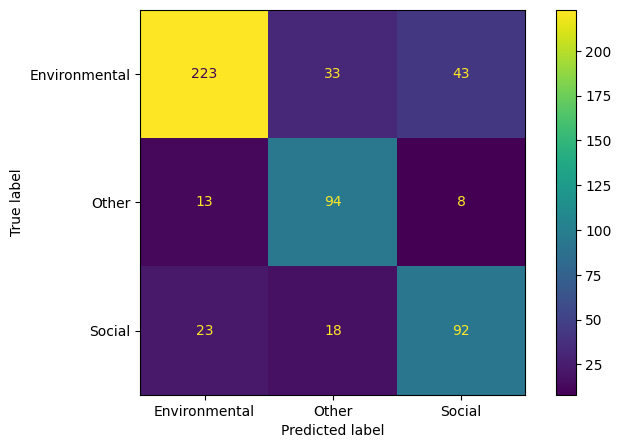

In [26]:

experiment_name = input("Enter experiment name: ")
predictions = clf.predict(X_test)
stats = evaluate_model(y_test, predictions, clf.classes_)
log_experiment_results(experiment_name, stats["macro avg"])

## What's next?
### Different models
With other models, you can get even better performance. For example, you could use 'BAAI/bge-large-en-v1.5'. See
- Overview of all tasks: MTEB Leaderboard https://huggingface.co/spaces/mteb/leaderboard
- Easy to get started: SentenceTransformershttps://www.sbert.net/docs/pretrained_models.html

### Applications
- Retrieval and ranking
- Clustering
- Search
- RAG
- Plagiarism detection via paraphrase mining
- Duplicate detection
- Multi-modal applications